In [302]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

sns.set_style("darkgrid")

In [303]:
similarity_df = pd.read_csv("similarities_1.0.tsv", sep="\t")
similarity_df

,ISO_1,LangName_1,ISO_2,LangName_2,Similarity,Robustness
0,abe,Western Abnaki,afr,Afrikaans,0.177,Low
1,abe,Western Abnaki,arb,Standard Arabic,0.094,Low
2,abe,Western Abnaki,bam,Bambara,0.522,Low
3,abe,Western Abnaki,bel,Belarusian,0.194,Low
4,abe,Western Abnaki,ben,Bengali,0.107,Low
...,...,...,...,...,...,...
23344,yua,Yucateco,zul,Zulu,0.120,Low
23345,yue,Yue Chinese,zho,Chinese,1.753,Medium
23346,yue,Yue Chinese,zsm,Standard Malay,0.017,Medium
23347,zho,Chinese,zul,Zulu,0.016,High


In [304]:
# get similarity from English to all other languages
eng_similarity_df = similarity_df[
    (similarity_df["LangName_1"] == "English") |
    (similarity_df["LangName_2"] == "English")
].copy()
eng_similarity_df["OtherLangName"] = eng_similarity_df.apply(
    lambda row: row["LangName_1"]
    if row["LangName_1"] != "English"
    else row["LangName_2"], axis=1
)
english_similarity = dict(eng_similarity_df[["OtherLangName", "Similarity"]].values)

In [305]:
fsi_df = pd.read_csv("fsi_study_time.csv")

In [306]:
fsi_df["Similarity"] = fsi_df["LangName"].map(english_similarity)
fsi_df

,LangName,Weeks,Category,Similarity
0,Danish,24,1,4.445
1,Dutch,24,1,6.081
2,French,30,1,9.665
3,Italian,24,1,6.757
4,Norwegian Bokmål,24,1,4.039
5,Portuguese,24,1,7.944
6,Romanian,24,1,6.194
7,Spanish,24,1,7.907
8,Swedish,24,1,4.158
9,German,36,2,4.720


<AxesSubplot: xlabel='Similarity', ylabel='Category'>

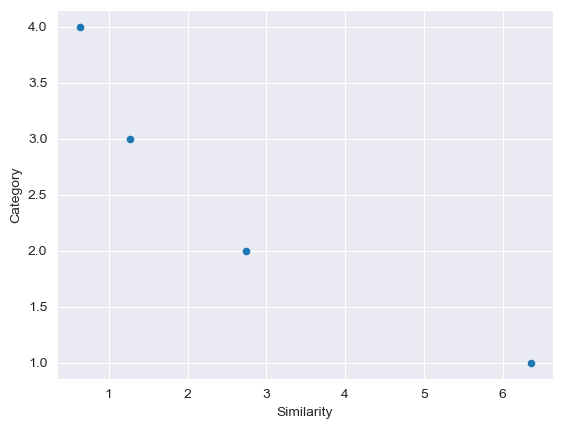

In [307]:
fsi_df.groupby("Category").mean(numeric_only=True).reset_index().plot.scatter(x="Similarity", y="Category")

<AxesSubplot: xlabel='Similarity', ylabel='Category'>

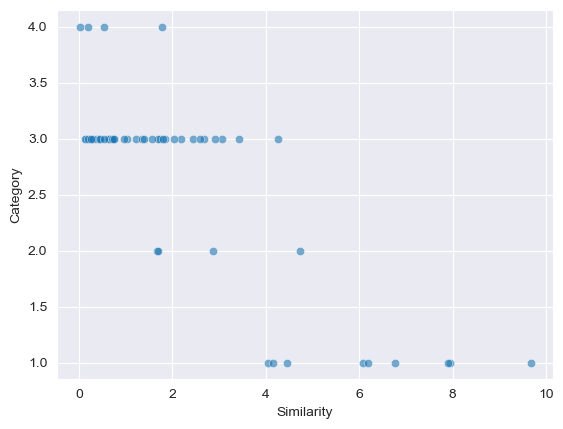

In [308]:
sns.scatterplot(x=fsi_df["Similarity"], y=fsi_df["Category"], alpha=0.6)

In [309]:
def get_similarity(similarity_df: pd.DataFrame, lang1: str, lang2: str) -> float:
    similarity_df = similarity_df[
        (similarity_df["LangName_1"].isin([lang1, lang2])) &
        (similarity_df["LangName_2"].isin([lang1, lang2]))
    ].copy()
    if len(similarity_df) != 1:
        raise ValueError(f"unexpectedly got {len(similarity_df)} rows when computing similarity between {lang1} and {lang2}")
    return similarity_df.iloc[0]["Similarity"]

In [310]:
known_langs = ["English", "Spanish"]

candidate_df = pd.read_csv("ethnologue_top_20.csv")
candidate_df = candidate_df[~candidate_df["Language"].isin(known_langs)].copy()
candidate_df[f"Similarity to {known_langs}"] = candidate_df["Language"].apply(
    lambda lang: max(
        get_similarity(similarity_df, known_lang, lang) for known_lang in known_langs
    )
)
candidate_df["Non-English Speakers"] = (
    candidate_df["Speakers"]
    * (1 - candidate_df["English Fraction"])
)

for language, similarity, non_english_speakers in zip(candidate_df["Language"], candidate_df[f"Similarity to {known_langs}"], candidate_df["Non-English Speakers"]):
    dominated = False
    for similarity2, non_english_speakers2 in zip(candidate_df[f"Similarity to {known_langs}"], candidate_df["Non-English Speakers"]):
        dominated |= (
            similarity2 > similarity
            and non_english_speakers2 > non_english_speakers
        )
    candidate_df.loc[candidate_df["Language"] == language, "Dominated"] = dominated

In [311]:
fig = px.scatter(
    candidate_df,
    x=f"Similarity to {known_langs}",
    y="Non-English Speakers",
    hover_data=["Language"],
    color="Dominated",
    text="Language"
).update_traces(
    textposition="top center"
)
fig.show()

In [312]:
fig.write_html("scatter.html")